# Simple Pendulum Equation
Little notebook to run some checks on `pandas_alive` under development mode, and to generate examples.
When using `conda` (either via Anaconda3 or Miniconda3) make sure to activate the right python env for this project in the Anaconda terminal before launching Jupyter; e.g. `conda activate py38-pandas_alive`, followed by `jupyter notebook`.

**NOTE**: when setting up custom figures for animations in `Matplotlib` make sure you use the `Figure()` syntax and not `figure()` instance type. The animations in this notebook take twice as long to be generated when changing from '**F**igure' to '**f**igure' syntax.

For example, instead of this: `fig, ax = plt.subplots()` try `fig = plt.Figure()` followed by `ax = fig.add_subplot()` 
OR  `fig = plt.Figure()` and `figs.add_gridspec(rows, columns)`.

More on '**F**igure' vs '**f**igure' can be found in this [SO entry](https://stackoverflow.com/questions/28631741/prevent-matplotlib-statefulness/28633419#28633419), and this [other SO entry](https://stackoverflow.com/questions/16334588/create-a-figure-that-is-reference-counted/16337909#16337909).

### Import Libraries

In [1]:
import platform
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../..')
import pandas_alive
from IPython.display import Video

# allow Jupyter to embed plots
%matplotlib inline

In [2]:
# check that main tools' versions in Python (conda) env match original development:
# see project 'requirements.txt' OR 'py38-pandas_alive.yml'
# print versions of main tools used
pyV = platform.python_version()
ipyV = ! ipython --version
pandasV = pd.__version__
jupV = ! jupyter notebook --version
npV = np.__version__
import matplotlib
pltV = matplotlib.__version__
p_a = pandas_alive.version
winV = platform.version()

ver_info = [[pyV, ipyV[0], pandasV, jupV[0], npV, pltV, p_a, winV]]
pkg_list = ["Python", "iPython", "Pandas", "Jupyter", "NumPy", "MatPlotLib", "pandas_alive", "Windows"]

print("Main package versions in this notebook:")
version_info = pd.DataFrame(data=ver_info, columns=pkg_list)
version_info

Main package versions in this notebook:


,Python,iPython,Pandas,Jupyter,NumPy,MatPlotLib,pandas_alive,Windows
0,3.8.5,7.18.1,1.0.3,6.1.3,1.19.2,3.2.1,0.2.3,10.0.19041


In [3]:
matplotlib.animation.writers.list()

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']

### Set Pendulum Input Data | Solve equations | Return `Pandas` df for Plotting

In [4]:
# Physical constants
g = 9.81
L = .4
mu = 0.2

THETA_0 = np.pi*70 / 180  # init angle = 70degs
THETA_DOT_0 = 0  # no init angVel
DELTA_T = 0.01  # time stepping
T = 1.5  # time period

In [5]:
# Definition of ODE (ordinary differential equation)
def get_theta_double_dot(theta, theta_dot):
    return -mu * theta_dot - (g / L) * np.sin(theta)

In [6]:
# Solution to the differential equation
def pendulum(t):
    # initialise changing values
    theta = THETA_0
    theta_dot = THETA_DOT_0
    delta_t = DELTA_T
    ang = []
    ang_vel = []
    ang_acc = []
    times = []
    for time in np.arange(0, t, delta_t):
        theta_double_dot = get_theta_double_dot(
            theta, theta_dot
        )
        theta += theta_dot * delta_t
        theta_dot += theta_double_dot * delta_t
        times.append(time)
        ang.append(theta)
        ang_vel.append(theta_dot)
        ang_acc.append(theta_double_dot)
    data = np.array([ang, ang_vel, ang_acc])
    return pd.DataFrame(data=data.T, index=np.array(times),columns=["angle", "ang_vel", "ang_acc"])

In [7]:
# units used for ref: ["angle [rad]", "ang_vel [rad/s]", "ang_acc [rad/s^2]"]
df = pendulum(T)
df.index.names = ["Time (s)"]
pd.set_option("display.max_rows", 4)
df

,angle,ang_vel,ang_acc
Time (s),,,
0.00,1.221730,-0.230460,-23.045962
0.01,1.219426,-0.460458,-22.999870
...,...,...,...
1.48,1.139250,-2.073416,-22.092251
1.49,1.118516,-2.292035,-21.861867


In [8]:
# generate dataFrame for animated bubble plot
df2 = pd.DataFrame(index=df.index)
df2["dx (m)"] = L*np.sin(df["angle"])
df2["dy (m)"] = -L*np.cos(df["angle"])
df2["ang_vel"] = abs(df["ang_vel"])
df2["size"] = df2["ang_vel"]*100  # scale angular vels to get nice size on bubble plot
df2

,dx (m),dy (m),ang_vel,size
Time (s),,,,
0.00,0.375877,-0.136808,0.230460,23.045962
0.01,0.375561,-0.137674,0.460458,46.045831
...,...,...,...,...
1.48,0.363328,-0.167310,2.073416,207.341601
1.49,0.359781,-0.174807,2.292035,229.203467


### `Pandas` static Plots

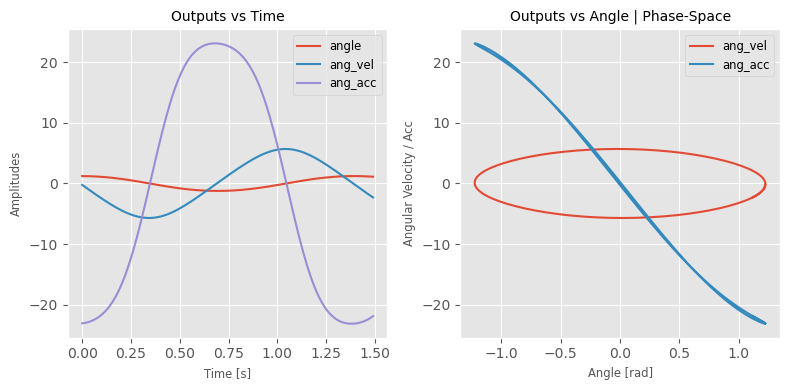

In [9]:
# static pandas plots
# 
# print(plt.style.available)
# NOTE: 2 lines below required in Jupyter to switch styles correctly
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use("ggplot")  # set plot style

fig, (ax1a, ax2b) = plt.subplots(1,2, figsize=(8,4), dpi=100)   # 1 row, 2 subplots
# fig.subplots_adjust(wspace=0.1)      # space subplots in row
fig.set_tight_layout(True)
fontsize = "small"

df.plot(ax=ax1a).legend(fontsize=fontsize)
ax1a.set_title("Outputs vs Time", fontsize="medium")
ax1a.set_xlabel('Time [s]', fontsize=fontsize)
ax1a.set_ylabel('Amplitudes', fontsize=fontsize);

df.plot(ax=ax2b, x="angle", y=["ang_vel", "ang_acc"]).legend(fontsize=fontsize)
ax2b.set_title("Outputs vs Angle | Phase-Space", fontsize="medium")
ax2b.set_xlabel('Angle [rad]', fontsize=fontsize)
ax2b.set_ylabel('Angular Velocity / Acc', fontsize=fontsize);

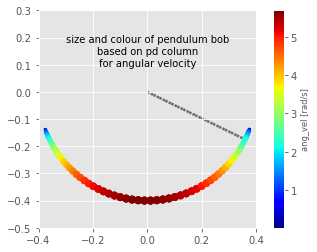

In [10]:
# sample scatter plot with colorbar
fig, ax = plt.subplots()
sc = ax.scatter(df2["dx (m)"], df2["dy (m)"], s=df2["size"]*.1, c=df2["ang_vel"], cmap="jet")
cbar = fig.colorbar(sc)
cbar.set_label(label="ang_vel [rad/s]", fontsize="small")
# sc.set_clim(350, 400)
ax.tick_params(labelrotation=0, labelsize="medium")
ax_scale = 1.
ax.set_xlim(-L*ax_scale, L*ax_scale)
ax.set_ylim(-L*ax_scale-0.1, L*ax_scale-0.1)
# make axes square: a circle shows as a circle
ax.set_aspect(1/ax.get_data_ratio())
ax.arrow(0, 0, df2["dx (m)"].iloc[-1], df2["dy (m)"].iloc[-1],
    color="dimgray", ls=":", lw=2.5, width=.0, head_width=0, zorder=-1
)
ax.text(0, 0.15 , s="size and colour of pendulum bob\nbased on pd column\nfor angular velocity",
       ha='center', va='center');

### `pandas_alive` Animations

#### LineChart Animation

In [11]:
# set up and generate animated line plot
# 
dpi = 100
ax_scale = 1.1
figsize = (3,3)
fontsize = "small"

# set up figure to pass onto `pandas_alive`
# NOTE: by using Figure (capital F) instead of figure() `FuncAnimation` seems to run twice as fast!
# fig1, ax1 = plt.subplots()
fig1 = plt.Figure()
ax1 = fig1.add_subplot()
fig1.set_size_inches(figsize)
ax1.set_title("Simple pendulum animation, L="+str(L)+"m", fontsize="medium")
ax1.set_xlabel("Time (s)", color='dimgray', fontsize=fontsize)
ax1.set_ylabel("Amplitudes", color='dimgray', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)


# pandas_alive
line_chart = df.plot_animated(filename="pend-line.mp4", kind='line', period_label={'x':0.05,'y':0.9},
                 steps_per_period=1, interpolate_period=False, period_length=50, period_fmt='Time:{x:10.2f}',
                 enable_progress_bar=True, fixed_max=True, dpi=100, fig=fig1
                )
plt.close()

Video('./pend-line.mp4', html_attributes="controls muted autoplay")

Generating LineChart, plotting ['angle', 'ang_vel', 'ang_acc']


#### ScatterChart Animation

In [12]:
# set up and generate animated scatter plot
# 

# set up figure to pass onto `pandas_alive`
# NOTE: by using Figure (capital F) instead of figure() `FuncAnimation` seems to run twice as fast!
fig1sc = plt.Figure()
ax1sc = fig1sc.add_subplot()
fig1sc.set_size_inches(figsize)
ax1sc.set_title("Simple pendulum animation, L="+str(L)+"m", fontsize="medium")
ax1sc.set_xlabel("Time (s)", color='dimgray', fontsize=fontsize)
ax1sc.set_ylabel("Amplitudes", color='dimgray', fontsize=fontsize)
ax1sc.tick_params(labelsize=fontsize)


# pandas_alive
scatter_chart = df.plot_animated(filename="pend-scatter.mp4", kind='scatter', period_label={'x':0.05,'y':0.9},
                 steps_per_period=1, interpolate_period=False, period_length=50, period_fmt='Time:{x:10.2f}',
                 enable_progress_bar=True, fixed_max=True, dpi=100, fig=fig1sc, size="ang_vel"
                )
plt.close()

print("Points size follows one of the pd columns: ang_vel")
Video('./pend-scatter.mp4', html_attributes="controls muted autoplay")

Generating ScatterChart, plotting ['angle', 'ang_vel', 'ang_acc']



Points size follows one of the pd columns: ang_vel


#### BarChartRace Animation

In [13]:
# set up and generate animated bar race chart
# 
# set up figure to pass onto `pandas_alive`
# NOTE: by using Figure (capital F) instead of figure() `FuncAnimation` seems to run twice as fast!
fig2 = plt.Figure()
ax2 = fig2.add_subplot()
fig2.set_size_inches(figsize)
ax2.set_title("Simple pendulum animation, L="+str(L)+"m", fontsize="medium")
ax2.set_xlabel("Amplitudes", color='dimgray', fontsize=fontsize)
ax2.set_ylabel("", color='dimgray', fontsize="x-small")
ax2.tick_params(labelsize=fontsize)


# pandas_alive
race_chart = df.plot_animated(filename="pend-race.mp4", kind='race', period_label={'x':0.05,'y':0.9},
                 steps_per_period=1, interpolate_period=False, period_length=50, period_fmt='Time:{x:10.2f}',
                 enable_progress_bar=True, fixed_max=False, dpi=100, fig=fig2
                )
plt.close()

Video('./pend-race.mp4', html_attributes="controls muted autoplay")

Generating BarChartRace, plotting ['angle', 'ang_vel', 'ang_acc']


#### BubbleChart Animation

In [18]:
# set up and generate bubble animated plot
# 

# set up figure to pass onto `pandas_alive`
# NOTE: by using Figure (capital F) instead of figure() `FuncAnimation` seems to run twice as fast!
fig3 = plt.Figure()
ax3 = fig3.add_subplot()
fig3.set_size_inches(figsize)
ax3.set_title("Simple pendulum animation, L="+str(L)+"m", fontsize="medium")
ax3.set_xlabel("Hor Displacement (m)", color='dimgray', fontsize=fontsize)
ax3.set_ylabel("Ver Displacement (m)", color='dimgray', fontsize=fontsize)
# limits & ratio below get the graph square
ax3.set_xlim(-L*ax_scale, L*ax_scale)
ax3.set_ylim(-L*ax_scale-0.1, L*ax_scale-0.1)
ratio = 1.  # this is visual ratio of axes
ax3.set_aspect(ratio/ax3.get_data_ratio())

ax3.arrow(0, 0, df2["dx (m)"].iloc[-1], df2["dy (m)"].iloc[-1],
    color="dimgray", ls=":", lw=1, width=.0, head_width=0, zorder=-1)


# pandas_alive
bubble_chart = df2.plot_animated(
    kind="bubble", filename="pend-bubble.gif",
    x_data_label="dx (m)", y_data_label="dy (m)", 
    size_data_label="size", color_data_label="ang_vel", cmap="jet",
    period_label={'x':0.05,'y':0.9}, vmin=None, vmax=None,
    steps_per_period=1, interpolate_period=False, period_length=50, period_fmt='Time:{x:10.2f}s',
    enable_progress_bar=True, fixed_max=False, dpi=dpi, fig=fig3
)
plt.close()

print("Bubble size & colour animates with pd data column for ang_vel.")
Video('./pend-bubble.mp4', html_attributes="controls muted autoplay")

Generating BubbleChart, plotting ['dx (m)', 'dy (m)', 'ang_vel', 'size']



Bubble size & colour animates with pd data column for ang_vel.


#### Multiple Plots Animations

In [15]:
# Combined plots
# 
fontsize="x-small"
# Otherwise titles overlap and subplots_adjust does nothing
from matplotlib import rcParams
rcParams.update({"figure.autolayout": False})

figs = plt.Figure(figsize=(9, 4), dpi=100)
figs.subplots_adjust(wspace=0.1)
gs = figs.add_gridspec(2, 2)

ax1 = figs.add_subplot(gs[0, 0])
ax1.set_xlabel("Time(s)", color='dimgray', fontsize=fontsize)
ax1.set_ylabel("Amplitudes", color='dimgray', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)

ax2 = figs.add_subplot(gs[1, 0])
ax2.set_xlabel("Amplitudes", color='dimgray', fontsize=fontsize)
ax2.set_ylabel("", color='dimgray', fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)

ax3 = figs.add_subplot(gs[:, 1])
ax3.set_xlabel("Hor Displacement (m)", color='dimgray', fontsize=fontsize)
ax3.set_ylabel("Ver Displacement (m)", color='dimgray', fontsize=fontsize)
ax3.tick_params(labelsize=fontsize)
# limits & ratio below get the graph square
ax3.set_xlim(-L*ax_scale, L*ax_scale)
ax3.set_ylim(-L*ax_scale-0.1, L*ax_scale-0.1)
ratio = 1.  # this is visual ratio of axes
ax3.set_aspect(ratio/ax3.get_data_ratio())

line_chart.ax = ax1
race_chart.ax = ax2
bubble_chart.ax = ax3


plots = [line_chart, race_chart, bubble_chart]
# pandas_alive combined using custom figure
pandas_alive.animate_multiple_plots(
    filename='./pend-combined.mp4', plots=plots, custom_fig=figs, dpi=100, enable_progress_bar=True,
    adjust_subplot_left=0.2, adjust_subplot_right=None,
    title="Simple pendulum animations, L="+str(L)+"m", title_fontsize="medium"
)
plt.close()

Video('./pend-combined.mp4', html_attributes="controls muted autoplay")

In [19]:
# This is here for testing that re-using axes with multiple plots behaves itself
# 
scatter_chart.ax = ax1sc
race_chart.ax = ax2
bubble_chart.ax = ax3

figs2 = figs
plots = [scatter_chart, race_chart, bubble_chart]
# pandas_alive combined using custom figure
pandas_alive.animate_multiple_plots(
    filename='./pend-combined-2.gif', plots=plots, custom_fig=figs2, dpi=100, enable_progress_bar=True,
    adjust_subplot_left=0.2, adjust_subplot_right=None,
    title="Simple pendulum animations, L="+str(L)+"m", title_fontsize="medium"
)
plt.close()

Video('./pend-combined-2.mp4', html_attributes="controls muted autoplay")

In [17]:
# checks on expected video FPS and Period
period_length = 50
steps_per_period = 1
fps = 1000 / period_length * steps_per_period
display("FPS: "+str(fps)+" | Time: "+str(1/fps)+"s")

'FPS: 20.0 | Time: 0.05s'